# Detecting VPC flow log anomalies

***Unsupervised anomaly detection on timeseries data with the Random Cut Forest algorithm.***

## License

Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: MIT-0

---

# Introduction
***

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on VPC flow log data.  Specifically, we have captured raw flow log data in an S3 bucket.  We then used a PySpark job to compute total bytes in and out over 1 minute windows per protocol.  We will use an RCF model to calculate anomaly scores for each 1-minute sum.

If you would like to know more please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Load data

***

*This notebook was created and tested on an ml.c5.xlarge notebook instance.*

The `bucket` and `prefixes` point to the output of the Glue job.

In [ ]:
import boto3
import botocore
import sagemaker
import sys


bucket = ''   # <--- specify a bucket you have access to
e_prefix = '' # <--- Specify S3 prefix pointing to egress output CSV
i_prefix = '' # <--- Specify S3 prefix pointing to ingress output CSV
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}'.format(bucket))

In [2]:
%%time

import pandas as pd
import urllib.request
import os

s3 = boto3.client('s3')

for f in [e_prefix, i_prefix]:
    f_local = os.path.split(f)[0]
    if os.path.exists(f_local):
        print("Skipping download for " + f)
    else:
        print("Starting download for " + f)
        s3.download_file(bucket, f, f_local)


Starting download for egress.csv/part-00000-841606c6-4879-4929-b6a2-2e6c11f3736b-c000.csv
Starting download for ingress.csv/part-00000-449be11c-ad69-4b01-931c-3501763e9fc1-c000.csv
CPU times: user 63.2 ms, sys: 11.9 ms, total: 75.2 ms
Wall time: 176 ms


In [4]:
dfIngress = pd.read_csv('ingress.csv',header=None,names=['protocol','avgbytes','starttime'])
dfIngress.head()

,protocol,avgbytes,starttime
0,6,2847.102273,2020-04-03T12:04:00.000Z
1,6,2861.619565,2020-04-03T11:58:00.000Z
2,17,76.000000,2020-04-04T02:29:00.000Z
3,17,76.000000,2020-04-03T08:19:00.000Z
4,17,76.000000,2020-04-07T11:40:00.000Z


In [5]:
dfEgress = pd.read_csv('egress.csv',header=None,names=['protocol','avgbytes','starttime'])
dfEgress.head()

,protocol,avgbytes,starttime
0,17,76.000000,2020-04-03T19:11:00.000Z
1,6,2230.770833,2020-04-04T09:04:00.000Z
2,17,76.000000,2020-04-03T17:41:00.000Z
3,6,2375.459459,2020-04-06T07:31:00.000Z
4,17,76.000000,2020-04-06T07:33:00.000Z


Human beings are visual creatures so let's take a look at a plot of the data.

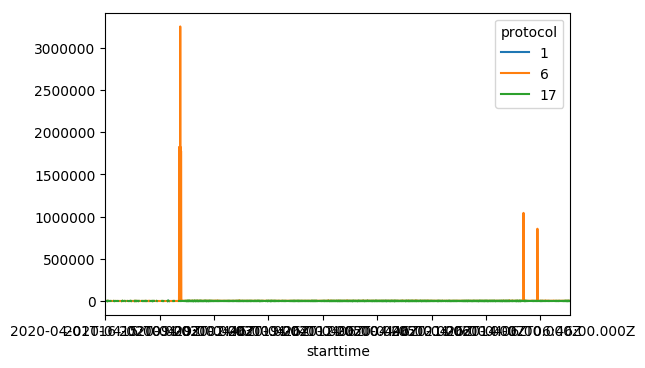

In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

dfIngress.pivot(index='starttime', columns='protocol', values='avgbytes').plot()

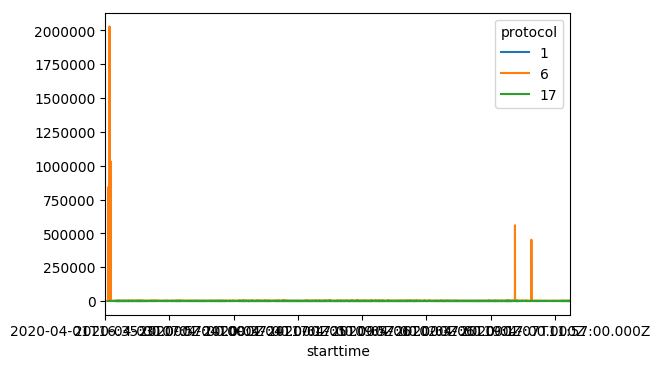

In [12]:
dfEgress.pivot(index='starttime', columns='protocol', values='avgbytes').plot()

# Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [19]:
dfIngressTrain = dfIngress.drop(columns=['starttime'])
dfIngressTrain.head()

,protocol,avgbytes
0,6,2847.102273
1,6,2861.619565
2,17,76.000000
3,17,76.000000
4,17,76.000000


In [22]:
dfIngressTrain.values

array([[   6.        , 2847.10227273],
       [   6.        , 2861.61956522],
       [  17.        ,   76.        ],
       ...,
       [  17.        ,   63.        ],
       [   6.        , 2619.79487179],
       [   6.        ,   42.66666667]])

In [ ]:
from sagemaker import RandomCutForest

session = sagemaker.Session()
d_prefix = 'training/ingress/data'
o_prefix = 'training/ingress'

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.2xlarge',
                      data_location='s3://{}/{}/'.format(bucket, d_prefix),
                      output_path='s3://{}/{}/output'.format(bucket, o_prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(dfIngressTrain.values.reshape(-1,1)))

If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training successfully completed and the output RCF model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [24]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2020-04-07-17-26-55-324


# Inference

***

We will:

* Create an inference endpoint
* Use the endpoint to get a few sample anomaly scores
* Compute anomaly scores for all of our training data
* Compute the z-score for each anomaly score `( |[x - mean] / stddev|)`
* Threshold based on z > 3

In [25]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

-------------!

In [26]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2020-04-07-17-26-55-324


In [27]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [28]:
p_data = dfIngressTrain.values.reshape(-1,1)
print(p_data[:6])
results = rcf_inference.predict(p_data[:6])

[[   6.        ]
 [2847.10227273]
 [   6.        ]
 [2861.61956522]
 [  17.        ]
 [  76.        ]]


In [29]:
print(results)

{'scores': [{'score': 0.6702065871}, {'score': 0.7697045839}, {'score': 0.6702065871}, {'score': 0.764334419}, {'score': 0.6995944636}, {'score': 0.5363648237}]}


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [31]:
results = rcf_inference.predict(p_data)
scores = [datum['score'] for datum in results['scores']]

In [33]:
# add scores to taxi data frame and print first few values
dfIngressTrain['score'] = pd.Series(scores)
dfIngressTrain.head()

,protocol,avgbytes,score
0,6,2847.102273,0.670207
1,6,2861.619565,0.769705
2,17,76.000000,0.670207
3,17,76.000000,0.764334
4,17,76.000000,0.699594


In [42]:
score_mean = dfIngressTrain['score'].mean()
score_std = dfIngressTrain['score'].std()
zscore_cutoff = 3

dfIngressTrain['zscore'] = abs((dfIngressTrain['score'] - score_mean) / score_std)
dfIngressTrain.head()

,protocol,avgbytes,score,zscore
0,6,2847.102273,0.670207,0.276372
1,6,2861.619565,0.769705,0.098533
2,17,76.000000,0.670207,0.276372
3,17,76.000000,0.764334,0.078298
4,17,76.000000,0.699594,0.165640


In [43]:
score_mean

0.7435544707132431

In [44]:
score_std

0.2653955250285757

In [46]:
anomalies = dfIngressTrain[dfIngressTrain['zscore'] > zscore_cutoff]
anomalies.shape

(206, 4)

In [47]:
print(f"% of events are anomalies: {round(100*(anomalies.shape[0] / dfIngressTrain.shape[0]),2)}")

% of events are anomalies: 1.43


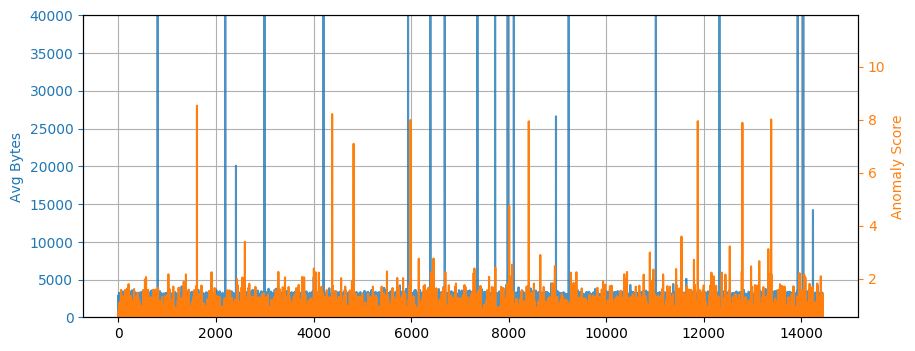

In [48]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dfIngressTrain['avgbytes'], color='C0', alpha=0.8)
ax2.plot(dfIngressTrain['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Avg Bytes', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

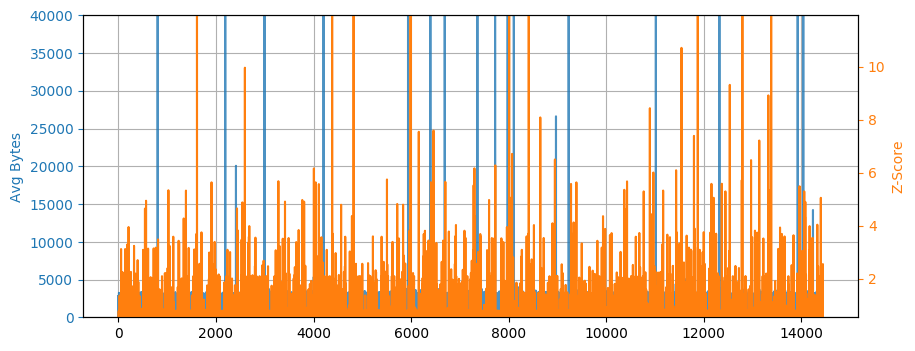

In [49]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dfIngressTrain['avgbytes'], color='C0', alpha=0.8)
ax2.plot(dfIngressTrain['zscore'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Avg Bytes', color='C0')
ax2.set_ylabel('Z-Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)